# Caricamento delle collezioni e collegamento al database
Il Database è composto da 4 collezioni: food, global_dataset, global_inflation, consumer_price_index.
- food: contiene i dati relativi all'inflazione del cibo per i paesi dell'est europa
    -  Ogni paese presenta un documento per ogni mese dell'anno con i relativi dati
- global_dataset: contiene i dati relativi all'inflazione per i paesi del mondo divisi per 5 categorie
    - Ogni paese presenta un documento per ogni Series Name con i relativi dati (Un singolo documento presenta  l'inflazione per ogni anno con l'anno usato come key)
- global_inflation: contiene i dati relativi all'inflazione per i paesi del mondo divisi per anno
    - Ogni paese è rappresentato da un solo documento con i valori di inflazione riportati come in global_dataset  

In [1]:
import pymongo
import utils 
import pandas as pd
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["ProgettoBD2"]
food = db["food"]
global_dataset = db["global_dataset"]
global_inflation = db["global_inflation"]
us_cpi = db["consumer_price_index"]

## Collection: Food
- Query per estrarre i paesi presenti nella collezione \
I paesi presenti nella collezione sono principalmente paesi dell'est Europa

In [8]:
countries = food.distinct("country")
countries

['Afghanistan',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Gambia, The',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Lao PDR',
 'Lebanon',
 'Liberia',
 'Mali',
 'Mozambique',
 'Myanmar',
 'Niger',
 'Nigeria',
 'Sbiriguda',
 'Somalia',
 'South Sudan',
 'Sudan',
 'Syrian Arab Republic',
 'Yemen, Rep.']

## Collection: Global Dataset
Lista dei paesi presenti nella collezione

In [9]:
countries = global_dataset.distinct("Country")
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 'Croatia',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Gui

L'inflazione è suddivisa in categorie.
- Query per la stampa delle categorie presenti nella collezione

In [10]:
global_dataset.distinct("Series Name")

['Energy Consumer Price Inflation',
 'Food Consumer Price Inflation',
 'Headline Consumer Price Inflation',
 'Official Core Consumer Price Inflation',
 'Producer Price Inflation']

# Estrazione dati su Unione Europea 
Si è deciso di analizzare i paesi dell'Unione Europea presenti nella collezione global_dataset

- Estrazione dei paesi dell'Unione Europea presenti nella collezione

In [11]:
query = {"Country Code": {"$in": ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]}}

europeanCountries = global_dataset.find(query)

europeanCountriesList = global_dataset.distinct("Country", query)
for country in europeanCountriesList:
    print(country)

Austria
Belgium
Bulgaria
Croatia
Cyprus
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Netherlands
Poland
Portugal
Romania
Slovak Republic
Slovakia
Slovenia
Spain
Sweden


Query che effettua la media anno per anno del tasso di inflazione nei paesi dell'unione europea di tutte le categorie.
In sostanza vengono eliminate le categorie aggregando i 5 valori per ogni anno in una media. 

In [12]:
# Esecuzione dell'aggregazione
result = utils.get_avg_infl_eur(global_dataset, europeanCountriesList)
# Stampa dei risultati
for doc in result:
    print(doc)

{'_id': 'Greece', '1970': 6.751991068666666, '1971': 3.6733333333333333, '1972': 4.206666666666666, '1973': 15.656666666666666, '1974': 31.424999999999997, '1975': 14.0875, '1976': 11.657499999999999, '1977': 12.265, '1978': 10.71, '1979': 20.7625, '1980': 30.6075, '1981': 27.3875, '1982': 18.995, '1983': 19.45, '1984': 17.875, '1985': 19.18, '1986': 13.462, '1987': 13.98, '1988': 10.682500000000001, '1989': 11.675, '1990': 21.759999999999998, '1991': 15.684000000000001, '1992': 15.19, '1993': 10.88, '1994': 0.9240000000000002, '1995': 17.253999999999998, '1996': 7.552, '1997': 2.1919999999999997, '1998': 2.83, '1999': 0.6540000000000001, '2000': 3.728, '2001': 2.976, '2002': 3.184, '2003': 3.528, '2004': 3.808, '2005': 4.448, '2006': 4.404, '2007': 2.8440000000000003, '2008': 6.63, '2009': -0.5660000000000001, '2010': 4.434, '2011': 5.228, '2012': 2.96, '2013': 0.42000000000000004, '2014': -1.998, '2015': -2.472, '2016': -1.358, '2017': 2.5140000000000002, '2018': 5.7219999999999995, 

Analizzata l'inflazione dell'intera Unione Europea negli anni
 

In [13]:
europeanCountriesList = global_dataset.distinct("Country", query)
result = utils.get_food_inflation_eur_per_year(global_dataset, europeanCountriesList)
output = {}

  # Riempimento del dizionario con i risultati
for doc in result: 
    doc.pop('_id')
    doc.pop('Indicator Type')
    doc.pop('Note')
    output.update(doc)

print(output)

KeyError: 'Indicator Type'

In [ ]:
import matplotlib.pyplot as plt

# Estrazione degli anni e dei valori di inflazione dal dizionario
anni = list(output.keys())
inflazione = list(output.values())

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.plot(anni, inflazione, marker='o', label='Inflazione annuale')
plt.xlabel('Anno')
plt.ylabel('Inflazione (%)')
plt.title('Inflazione annuale nell\'Unione Europea')
plt.xticks(rotation=90)
plt.legend()
plt.show()

## Integrazione con food: primi passi
Nel Dataset Food non sono presenti molti paesi dell'Unione Europea, per questo motivo si è deciso di integrare i dati di food con quelli di global_dataset. \
Viene eseguita una query per estrarre i dati dell'inflazione dei paesi europei sul cibo da global_dataset sfruttando il campo Series Name per estrarre solo i valori inerenti il campo "Food Consumer Price Inflation". \
 Questa query è stata effettuata utilizzando i Country Code dei paesi europei. 


In [14]:
#todo: Implementare in app come sotto funzione dell'inflazione sul cibo totale

europeanCountriesList = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]

result = utils.get_eu_food_infl_countries(global_dataset, europeanCountriesList)

for doc in result:
    doc.pop('_id')
    doc.pop('Indicator Type')
    doc.pop('Note')
    print(doc)


{'1970': 4.42, '1971': 3.21, '1972': 5.32, '1973': 7.19, '1974': 8.14, '1975': 6.05, '1976': 5.31, '1977': 5.59, '1978': 2.93, '1979': 2.48, '1980': 4.5, '1981': 5.89, '1982': 4.23, '1983': 2.13, '1984': 5.44, '1985': 2.0, '1986': 1.99, '1987': 0.24, '1988': 0.12, '1989': 0.78, '1990': 2.82, '1991': 4.08, '1992': 3.71, '1993': 2.27, '1994': 1.38, '1995': -1.72, '1996': 0.13, '1997': 1.53, '1998': 1.93, '1999': -0.63, '2000': 0.65, '2001': 3.64, '2002': 1.34, '2003': 1.79, '2004': 1.92, '2005': 1.24, '2006': 1.88, '2007': 4.21, '2008': 6.29, '2009': 0.2, '2010': 0.48, '2011': 4.24, '2012': 3.19, '2013': 3.47, '2014': 1.94, '2015': 0.83, '2016': 0.73, '2017': 2.37, '2018': 1.52, '2019': 1.02, '2020': 2.33, '2021': 0.78, '2022': 10.23, 'Country Code': 'AUT', 'IMF Country Code': 122, 'Country': 'Austria', 'Series Name': 'Food Consumer Price Inflation'}
{'1970': 3.5, '1971': 1.9, '1972': 6.6, '1973': 8.0, '1974': 9.4, '1975': 11.2, '1976': 6.1, '1977': 6.1, '1978': 1.5, '1979': 0.5, '1980':

### Query MongoDB per l'integrazione dei dati atta a raggruppare i dati di food per anno
Inizialmente i dati erano raggruppati per mese, è stata preso in considerazione il valore Inflation dove presente ed è stato sommato in modo da avere il valore annuale piuttosto che mensile. \n



In [29]:
pipeline = [
    {
        "$addFields": {
            "year": {"$year": "$date"},  # Estrai l'anno dalla data
        }
    },
    {
        "$group": {
            "_id": {"country": "$country", "year": "$year"},  # Raggruppa per country e year
            "inflationSum": {"$sum": "$Inflation"},  # Somma i valori di inflation
        }
    },
    {
        "$project": {
            "_id": 0,
            "country": "$_id.country",
            "year": "$_id.year",
            "Inflation": "$inflationSum",
        }
    },
]

grouped_data = list(food.aggregate(pipeline))

In [30]:
grouped_data

[{'country': 'Guinea-Bissau', 'year': 2020, 'Inflation': -140.4},
 {'country': 'Liberia', 'year': 2012, 'Inflation': 85.77},
 {'country': 'Gambia, The', 'year': 2010, 'Inflation': 6.28},
 {'country': 'Liberia', 'year': 2016, 'Inflation': 78.25},
 {'country': 'Mozambique', 'year': 2014, 'Inflation': -25.42},
 {'country': 'Somalia', 'year': 2018, 'Inflation': -57.01},
 {'country': 'Syrian Arab Republic', 'year': 2017, 'Inflation': 44.12},
 {'country': 'Chad', 'year': 2008, 'Inflation': 366.34000000000003},
 {'country': 'Burundi', 'year': 2017, 'Inflation': 320.67},
 {'country': 'Myanmar', 'year': 2015, 'Inflation': 148.8},
 {'country': 'Lao PDR', 'year': 2014, 'Inflation': 133.62},
 {'country': 'Lebanon', 'year': 2012, 'Inflation': 0},
 {'country': 'Liberia', 'year': 2011, 'Inflation': 82.89},
 {'country': 'Myanmar', 'year': 2020, 'Inflation': -4.299999999999999},
 {'country': 'Gambia, The', 'year': 2018, 'Inflation': 53.31},
 {'country': 'Gambia, The', 'year': 2011, 'Inflation': 18.9900

# Integrazione dei dati completa del data_set food con global Dataset
- Vengono estratti i paesi distinti presenti in global_dataset e in food, viene eseguita la query per ottenere l'inflazione di ogni paese relativa al campo alimentare in global_dataset attraverso il campo Series Name. \n
- Viene in seguito definita una lista dei paesi presenti nel risultato della query e vengono ad essi aggiunti i paesi mancanti presenti nel dataset food con i relativi dati 
- Sono risultati alla fine solo due paesi mancanti: Somalia e South Sudan. I valori dell'inflazione sono stati calcolati nella cella precedente effettuando una somma dei valori mensili per ottenere quelli annuali.

In [31]:
#todo: Implementare in app

country_codes = global_dataset.distinct("Country Code")
food_country_list = food.distinct("country")

result = list(utils.get_eu_food_infl_countries(global_dataset, country_codes))
grouped_data_dict = {(doc['country'], doc['year']): doc.get('Inflation', 0) for doc in grouped_data if 'country' in doc and 'year' in doc}
existing_countries = [doc['Country'] for doc in result]

for doc in result:
    doc.pop('_id')
    doc.pop('Indicator Type')
    doc.pop('Note')

for country in food_country_list:
    if country not in existing_countries:
        for year in range(1980, 2025): 
            infl = grouped_data_dict.get((country, year))
            if infl is not None:
                result.append({
                    'country': country,
                    'year': year,
                    'infl': infl
                })
                
for doc in result:
    print(doc)
        

{'2002': 3.4, '2003': 2.63, '2004': 3.33, '2005': 3.75, '2006': 5.18, '2007': 13.67, '2008': 11.16, '2009': 4.62, '2010': -2.29, '2011': 4.29, '2012': 2.66, '2013': 0.18, '2014': 2.15, '2015': 2.17, '2016': -0.17, '2017': 0.66, '2018': 7.45, '2019': 12.82, '2020': 10.99, 'Country Code': 'ABW', 'IMF Country Code': 314, 'Country': 'Aruba', 'Series Name': 'Food Consumer Price Inflation'}
{'1981': 25.4, '1982': 23.6, '1983': 16.9, '1984': 18.3, '1985': 10.7, '1986': -1.8, '1987': 24.2, '1988': 22.4, '1989': 68.4, '1990': 78.3, '2006': 6.26, '2007': 12.34, '2008': 41.07, '2009': -13.35, '2010': -0.28, '2011': 10.67, '2012': 4.73, '2013': 7.57, '2014': 7.74, '2015': -0.84, '2016': 5.67, '2017': 6.94, '2018': -1.05, '2019': 3.79, '2020': 5.83, 'Country Code': 'AFG', 'IMF Country Code': 512, 'Country': 'Afghanistan', 'Series Name': 'Food Consumer Price Inflation'}
{'2005': 21.36, '2006': 17.25, '2007': 14.11, '2008': 18.5, '2009': 18.14, '2010': 17.42, '2011': 14.95, '2012': 12.77, '2013': 10.

## Collection: Global Inflation
Lista dei paesi presenti nella collezione

In [18]:
countries = global_inflation.distinct("country_name")
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 "China, People's Republic of",
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep. of the',
 'Congo, Republic of ',
 'Costa Rica',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 

#### Estrazione Paese con maggiore inflazione in base all'anno

In [19]:
# Query per trovare il paese con la massima inflazione in un anno specifico
anno = 1991
max_inflation = utils.get_max_infl_year(global_inflation, anno)

country_max_infl = global_inflation.find_one({"_id": max_inflation.next()['_id']})
country_name = country_max_infl['country_name']

print(f"Il paese con la maggiore inflazione nel {anno} è: {country_name} con un valore di {country_max_infl[str(anno)]}%")

Il paese con la maggiore inflazione nel 1991 è: Congo, Dem. Rep. of the con un valore di 2154.4%


In [20]:
del country_max_infl['_id']
del country_max_infl['country_name']
del country_max_infl['indicator_name']

## Plot dell'inflazione annuale per il paese con la maggiore inflazione precedentemente calcolata

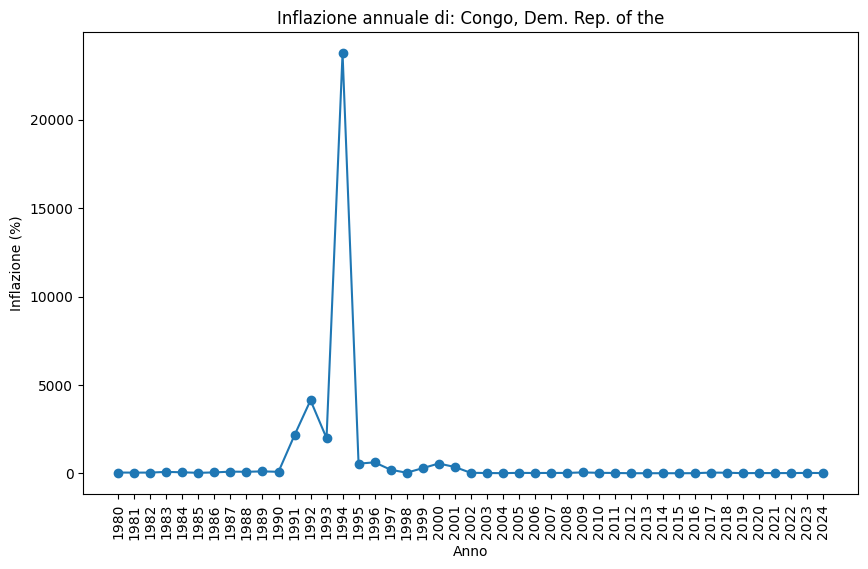

In [21]:
import matplotlib.pyplot as plt

anni = list(country_max_infl.keys())
inflazione = list(country_max_infl.values())
plt.figure(figsize=(10, 6))
plt.plot(anni, inflazione, marker='o', label='Inflazione annuale')
plt.xlabel('Anno')
plt.ylabel('Inflazione (%)')
plt.title(f'Inflazione annuale di: {country_name}')
plt.xticks(rotation=90)
plt.show()

# Inflazione media per paese

In [22]:
#todo: Implementare in app

country_name = "Italy"
avg_ita_infl = utils.get_avg_infl_years(global_inflation, country_name)
print(f"L'inflazione media in {country_name} dal 1980 al 2024 è {avg_ita_infl.next()['avgInflation']:.2f}%")

L'inflazione media in Italy dal 1980 al 2024 è 4.66%


# Analisi dell'inflazione negli anni dato il paese 

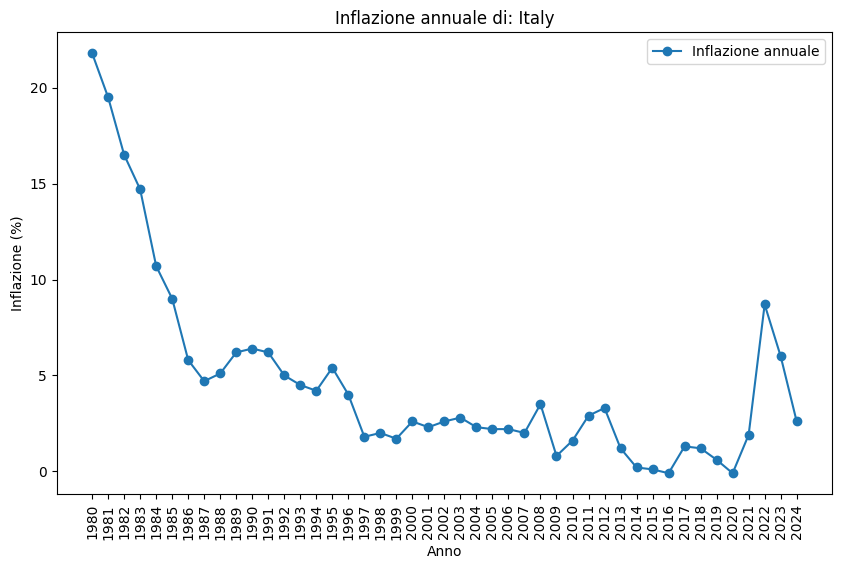

In [23]:
country = "Italy"
inflation_values, years = utils.get_inflation_by_country(global_inflation, country)

plt.figure(figsize=(10, 6))
plt.plot(inflation_values, years, marker='o', label='Inflazione annuale')
plt.xlabel('Anno')
plt.ylabel('Inflazione (%)')
plt.title(f'Inflazione annuale di: {country_name}')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Operazioni CRUD
## Inserimento
Sfruttando le caratteristiche NoSQL generalizziamo l'inserimento con un documento di questa forma: country_name, inflation_values, year. \n

In [2]:
utils.insert_into_collection(global_inflation, "Sbiriguda",69.69, 2023)
utils.insert_into_collection(food, "Sbiriguda",69.69, 2023)
utils.insert_into_collection(global_dataset, "Sbiriguda",69.69, 2023)

InsertOneResult(ObjectId('6669ada66100eea5aec0edea'), acknowledged=True)

## Cancellazione
La cancellazione per semplicità è stata gestita per paese piuttosto che per documento. E' possibile cancellare i documenti relativi ad un paese da tutti i dataset.

In [3]:
utils.delete_from_collection(global_inflation, "Sbiriguda")
utils.delete_from_collection(food, "Sbiriguda")
utils.delete_from_collection(global_dataset, "Sbiriguda")

1